In [1]:
import fiona
import geopandas as gpd
import json
from shapely.geometry import Point
import pyproj

fiona.drvsupport.supported_drivers['LIBKML'] = 'rw'

with fiona.open("PlanningBoundaryArea.kml") as collection:
    gdf = gpd.GeoDataFrame.from_features(collection)

with open('Car_Park_Details.json', 'r') as file:
    carparks = json.load(file)

transformer = pyproj.Transformer.from_crs(
    "EPSG:3414",  # SVY21 (Singapore)
    "EPSG:4326"   # WGS84
)

In [37]:
gdf["carparks"] = 0
carpark_counts = [0] * len(gdf)

def update_gdf(point):
    for index, row in gdf.iterrows():
        if(row['geometry'].contains(point)):
            carpark_counts[index] += 1
            return

for carpark in carparks["Result"]:
    if len(carpark["geometries"]) == 0:
        continue

    x, y = carpark["geometries"][0]["coordinates"].split(",")
    lon, lat = transformer.transform(float(x), float(y))
    point = Point(lat, lon)
    update_gdf(point)

for i in range(len(gdf)):
    gdf.loc[i, 'carparks'] = carpark_counts[i]

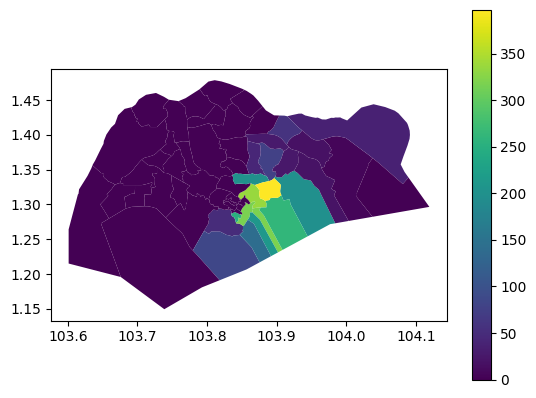

In [38]:
p = gdf.plot("carparks", legend=True)
p.figure.savefig("carparks.png")